# Top of notebook

In [1]:
import numpy as np
import glob
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import mpl_toolkits.mplot3d.axes3d as p3


# %matplotlib widget
# %matplotlib inline
# %matplotlib widget
%matplotlib tk

## Loading data and visualizations

The cell below loads a few npy files. They each have pose data from the original motinocapture files, however, **they are already
egocentered** such that the rat always looks to the right.

In [2]:
dnames = glob.glob('mocap_clean_eh5/*.npy')
egoh5s = []
for dname in dnames:
    egoh5s.append(np.load(dname, allow_pickle=True))

In [3]:
print(np.array(egoh5s).shape)

(1, 247197, 57)


In [6]:
connections2 = [[5, 4, 6,5], [4,17,18], [17,11,12,18], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig = plt.figure()
ax = p3.Axes3D(fig, auto_add_to_figure=False )
fig.add_axes(ax)

def animfunc(t, skip=1):
    ax.clear()
    
    lines = []
    frame = t*skip
    figure = egoh5s[0]
    for conn in connections2:
        x = [3*i for i in conn]
        y = [i+1 for i in x]
        z = [i+2 for i in x]
        lines.append(ax.plot(figure[frame, x], figure[frame, y],  figure[frame, z], linewidth=3))
    ax.set_title('(%i, %i)'%((t, t*skip)))
    return lines,
        
anim = FuncAnimation(fig, animfunc, frames=100, fargs=(50,), interval=500, repeat=False)

In [7]:
anim.event_source.stop()        

Let's plot the center of mass of these poses. If they are not very erronous, they should all lie in a clumb near origin. 

In [8]:
# np.argwhere(coms[:,0])

In [9]:
ax.get_xlim()

(-31.32535658658453, 113.38318342566257)

In [13]:
alleh5s = np.concatenate(egoh5s, axis=0)
print(alleh5s.shape)
# alleh5s = alleh5s.reshape((-1, alleh5s.shape[1]//3, 3))
alleh5s = alleh5s.reshape((-1, 19, 3))
coms = np.mean(alleh5s, axis=1)
print(coms.shape)
print(coms[:,0].shape)

# fig6 = plt.figure()
# ax6 = p3.Axes3D(fig6, auto_add_to_figure=False)
# fig6.add_axes(ax6)
# ax6.scatter(coms[:,0], coms[:,1], coms[:,2], s=1)
fig, ax = plt.subplots()
ax.set_title("Center of Mass")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.scatter(coms[:,0], coms[:,1], s=1)

(247197, 57)
(247197, 3)
(247197,)


Zoom in in the figure above to enclose only the central blob. Then run the cell below to select points that are in the central blob.

In [14]:
xlim, ylim = ax.get_xlim(), ax.get_ylim()

inds = np.where((coms[:,0]<xlim[1]) & (coms[:,0]>xlim[0]) & (coms[:,1]<ylim[1]) & (coms[:,1]>ylim[0]))[0]


connections2 = [[5, 4, 6, 5], [4,17,18], [17,11,12,18], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig2 = plt.figure()
ax2 = p3.Axes3D(fig2, auto_add_to_figure=False)
fig2.add_axes(ax2)

def animfunc(t):
    ax2.clear()
    lines = []
    for conn in connections2: 
        x = alleh5s[inds[t], conn, 0]
        y = alleh5s[inds[t], conn, 1]
        z = alleh5s[inds[t], conn, 2]
        lines.append(ax2.plot(x, y, z, linewidth=3))
    ax2.set_title('(%i/%i, %i)'%((t, len(inds), inds[t])))
#     ax2.set_xlim([-250, 250])
#     ax2.set_ylim([-300, 300])
    return lines,

anim = FuncAnimation(fig2, animfunc, frames=len(inds), interval=500, repeat=False)


In [15]:
anim.event_source.stop()

So not all poses have a center of mass at origin, so we don't have a very clean pose data to start with. 

In [16]:
alleh5s_clean = alleh5s[inds]

## Training AE model 

Before moving on to a variationa autoencoder, let's try to train a simple autoencode, and see if it is able to reconstruct poses with sufficiently low error. 
This also gives opportunity to change different parameters (activation functions, number of units) for the overall network architecture.

In [17]:
alleh5s_clean.shape[0]/alleh5s.shape[0]

1.0

In [18]:
trainx = alleh5s_clean[::30].reshape((-1, 57)).astype('float32')
valx = alleh5s_clean[15::60].reshape((-1, 57)).astype('float32')
print(trainx.shape, valx.shape)
print(trainx.min(), trainx.max())

(8240, 57) (4120, 57)
-167.06784 174.58513


In [19]:
import tensorflow as tf
import tensorflow.keras as k
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [20]:
AE = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation=None),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57, activation=None)])

AE.compile('adam', 'mse')

In [21]:
AE.fit(trainx, trainx, batch_size=64, epochs=50, validation_data=(valx, valx), callbacks = [tf.keras.callbacks.ModelCheckpoint(
    'MotionCapture_AE.h5', monitor="val_loss", verbose=1, save_best_only=True)])

Epoch 1/50
129/129 [==============================] - 1s 4ms/step - loss: 669.9118 - val_loss: 121.3683

Epoch 00001: val_loss improved from inf to 121.36828, saving model to MotionCapture_AE.h5
Epoch 2/50
129/129 [==============================] - 0s 2ms/step - loss: 81.4802 - val_loss: 59.9620

Epoch 00002: val_loss improved from 121.36828 to 59.96202, saving model to MotionCapture_AE.h5
Epoch 3/50
129/129 [==============================] - 0s 2ms/step - loss: 49.0400 - val_loss: 40.7644

Epoch 00003: val_loss improved from 59.96202 to 40.76439, saving model to MotionCapture_AE.h5
Epoch 4/50
129/129 [==============================] - 0s 2ms/step - loss: 34.9498 - val_loss: 28.0888

Epoch 00004: val_loss improved from 40.76439 to 28.08879, saving model to MotionCapture_AE.h5
Epoch 5/50
129/129 [==============================] - 0s 2ms/step - loss: 24.2302 - val_loss: 21.0215

Epoch 00005: val_loss improved from 28.08879 to 21.02148, saving model to MotionCapture_AE.h5
Epoch 6/50
129/1


Epoch 00043: val_loss improved from 7.98064 to 7.94301, saving model to MotionCapture_AE.h5
Epoch 44/50
129/129 [==============================] - 0s 2ms/step - loss: 7.6799 - val_loss: 7.7690

Epoch 00044: val_loss improved from 7.94301 to 7.76898, saving model to MotionCapture_AE.h5
Epoch 45/50
129/129 [==============================] - 0s 2ms/step - loss: 7.6098 - val_loss: 7.7786

Epoch 00045: val_loss did not improve from 7.76898
Epoch 46/50
129/129 [==============================] - 0s 3ms/step - loss: 7.5235 - val_loss: 7.6408

Epoch 00046: val_loss improved from 7.76898 to 7.64076, saving model to MotionCapture_AE.h5
Epoch 47/50
129/129 [==============================] - 0s 2ms/step - loss: 7.4554 - val_loss: 7.6315

Epoch 00047: val_loss improved from 7.64076 to 7.63151, saving model to MotionCapture_AE.h5
Epoch 48/50
129/129 [==============================] - 0s 2ms/step - loss: 7.3821 - val_loss: 7.5241

Epoch 00048: val_loss improved from 7.63151 to 7.52407, saving model t

#all data AE error 70

#clean data AE error 22



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='sigmoid'), #24 with 'tanh' here #16 with None!!!
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 61



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation=None),
            tf.keras.layers.Dense(16, activation=None),
            tf.keras.layers.Dense(8, activation='tanh'),
            tf.keras.layers.Dense(16, activation=None),
            tf.keras.layers.Dense(32, activation=None),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 41 with wonky activations - 



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='tanh'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 38 with wonky activations - 



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(8, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='tanh'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57, activation=None)])



#clean data AE error 66 with  - 



            tf.keras.layers.InputLayer(input_shape=(57,)),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='sigmoid'),
            tf.keras.layers.Dense(8, activation='sigmoid'),
            tf.keras.layers.Dense(16, activation='sigmoid'),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(57, activation=None)])


In [22]:
valx_pred = AE.predict(valx, verbose=1)

129/129 [==============================] - 0s 1ms/step


In [23]:
connections2 = [[5, 4, 6, 5], [4,17,18], [17,11,12,18], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig3 = plt.figure()
ax3 = p3.Axes3D(fig3, auto_add_to_figure=False)
fig3.add_axes(ax3)

def animfunc(t, skip=1):
    ax3.clear()
    lines = []
    for conn in connections2:
        x = [3*i for i in conn]
        y = [i+1 for i in x]
        z = [i+2 for i in x]
        lines.append(ax3.plot(valx[t*skip, x], valx[t*skip, y], valx[t*skip, z], color='royalblue'))
        lines.append(ax3.plot(valx_pred[t*skip, x], valx_pred[t*skip, y], valx_pred[t*skip, z], color='firebrick'))
    ax3.set_title('(%i, %i)'%((t, t*skip)))
    return lines,

anim = FuncAnimation(fig3, animfunc, frames=50, fargs=(10,), interval=500, repeat=False)       

Seems like the errors in the validation set are very close to less than 3px. That is great, 
especially since we did not normalize our data in any way. 

In [67]:
anim.event_source.stop()        

In [24]:
errors = np.abs(valx_pred-valx).reshape((-1, 19, 3))
np.mean(errors, axis=(0,1))

array([1.7310153, 1.5736636, 1.9898667], dtype=float32)

We can get the latent layer values by defining a new model with output from layer 2 of our autoencoder

In [25]:
AE.layers

In [26]:
AE2 = k.models.Model(inputs=AE.input, outputs=AE.layers[2].output)

In [27]:
#check if the weights are same 
[np.all(w1==w2) for w1,w2 in zip(AE.get_weights(),AE2.get_weights())]

[True, True, True, True, True, True]

In [28]:
alleh5s_clean_ae = AE2.predict(alleh5s_clean.reshape((-1, 57)).astype('float32'), verbose=1)
alleh5s_clean_ae.shape

7708/7708 [==============================] - 6s 735us/step


(246652, 8)

## Training a VAE Model

Now that we have some idea of what network architecture works for our data, we can try to add the variational inference 
inside the network. 

In [29]:
class Sampling(k.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [30]:
class VAEModel(k.Model):
    def __init__(self, latent_dim=8, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.encoder = self.create_encoder()
        self.decoder = self.create_decoder()
        self.total_loss_tracker = k.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = k.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = k.metrics.Mean(name="kl_loss")

    def create_encoder(self):
        encoder_input = tf.keras.Sequential([
                    tf.keras.layers.InputLayer(input_shape=(57,)),
                    tf.keras.layers.Dense(32, activation='relu'),
                   tf.keras.layers.Dense(16, activation='relu'),])

        z_mean = k.layers.Dense(self.latent_dim, name="z_mean", activation='tanh')(encoder_input.output)
        z_log_var = k.layers.Dense(self.latent_dim, name="z_log_var", activation='tanh')(encoder_input.output)

        z = Sampling()([z_mean, z_log_var])
        encoder = k.Model(encoder_input.input, [z_mean, z_log_var, z], name="encoder")        
        return encoder
    
    def create_decoder(self):
        decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
           tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(57)])
        return decoder

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                    k.losses.mean_squared_error(data, reconstruction))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return reconstruction

<IPython.core.display.Javascript object>


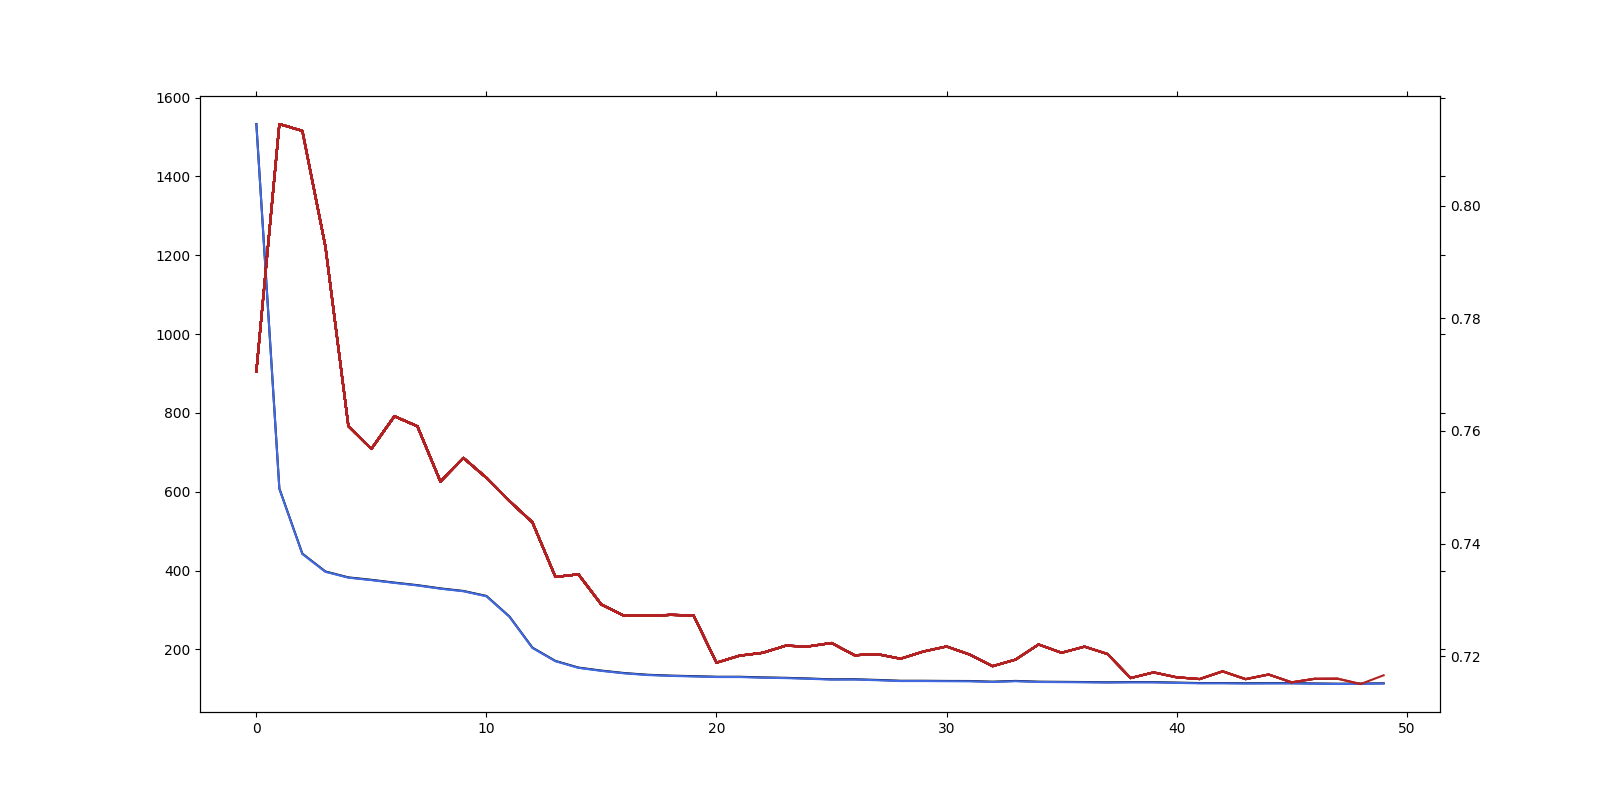

In [31]:
figloss, axloss = plt.subplots(figsize=(16, 8))
axloss2 = axloss.twinx()

class LossPlot(k.callbacks.Callback):
    def __init__(self):
        self.losses = [0,0,0]
        
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        self.losses = np.vstack([self.losses, [logs['loss'], logs['reconstruction_loss'], logs['kl_loss']]])
        axloss.clear()
        axloss.plot(self.losses[1:,0], '-', color='black', label='loss')
        axloss.plot(self.losses[1:,1], '-', color='royalblue', label='loss (recon)')
        axloss2.plot(self.losses[1:,2], '-', color='firebrick', label='loss (kl)')
        figloss.canvas.draw()

In [32]:
vae = VAEModel(latent_dim=8)
vae.compile(optimizer=k.optimizers.Adam(learning_rate=0.001))
vae.fit(trainx, epochs=50, batch_size=64, workers=1, callbacks=LossPlot())

Epoch 1/50
129/129 [==============================] - 1s 2ms/step - loss: 1721.1624 - reconstruction_loss: 1532.4070 - kl_loss: 0.7706
Epoch 2/50
129/129 [==============================] - 0s 2ms/step - loss: 714.6185 - reconstruction_loss: 607.4051 - kl_loss: 0.8146
Epoch 3/50
129/129 [==============================] - 0s 3ms/step - loss: 458.6078 - reconstruction_loss: 442.1735 - kl_loss: 0.8133
Epoch 4/50
129/129 [==============================] - 0s 2ms/step - loss: 400.8618 - reconstruction_loss: 397.0123 - kl_loss: 0.7928
Epoch 5/50
129/129 [==============================] - 0s 2ms/step - loss: 390.3628 - reconstruction_loss: 382.0163 - kl_loss: 0.7609
Epoch 6/50
129/129 [==============================] - 0s 2ms/step - loss: 378.4098 - reconstruction_loss: 375.8134 - kl_loss: 0.7568
Epoch 7/50
129/129 [==============================] - 0s 2ms/step - loss: 370.6680 - reconstruction_loss: 368.7832 - kl_loss: 0.7626
Epoch 8/50
129/129 [==============================] - 0s 2ms/step -

In [33]:
valx_pred_vae = vae.predict(valx, verbose=1)

129/129 [==============================] - 0s 1ms/step


<IPython.core.display.Javascript object>


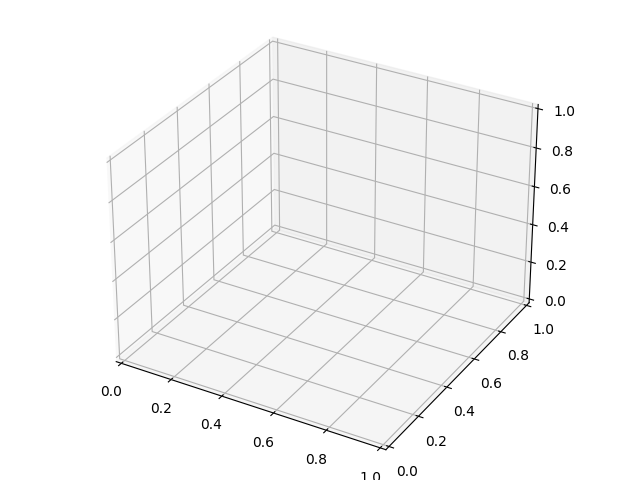

In [66]:
connections2 = [[5, 4, 6, 5], [4,17,18], [17,11,12,18], [0,2,15,17,16,3,1], [13,9,7,18,8,10,14]]

fig4 = plt.figure()
ax4 = p3.Axes3D(fig4, auto_add_to_figure=False)
fig4.add_axes(ax4)

def animfunc(t, skip=1):
    ax4.clear()
    lines = []
    for conn in connections2:
        x = [3*i for i in conn]
        y = [i+1 for i in x]
        z = [i+2 for i in x]
        lines.append(ax4.plot(valx[t*skip, x], valx[t*skip, y], valx[t*skip, z], color='royalblue'))
        lines.append(ax4.plot(valx_pred_vae[t*skip, x], valx_pred_vae[t*skip, y], valx_pred_vae[t*skip, z], color='firebrick'))
    ax4.set_title('(%i, %i)'%((t, t*skip)))
    return lines,

anim = FuncAnimation(fig4, animfunc, frames=100, fargs=(100,), interval=500, repeat=False)

Seems like the errors in the validation set are around 7px (they were 3px w/ AE)

In [59]:
errors = np.abs(valx_pred_vae-valx).reshape((-1, 19, 3))
np.mean(errors, axis=(0,1))

array([7.948758, 7.543772, 7.229991], dtype=float32)

The latent layer values can be obtained using the VAE 'encoder' sub-model. 

In [60]:
z_mean, z_log_var, z = vae.encoder.predict(alleh5s_clean.reshape((-1, 57)), verbose=1)

7708/7708 [==============================] - 8s 1ms/step


In [61]:
print(z_mean.shape, z_log_var.shape, z.shape)

(246652, 8) (246652, 8) (246652, 8)
